In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import warnings
import geopandas as gpd
from file_paths_and_consts import *

## HELPER Functions

In [2]:
warnings.filterwarnings('ignore')

def get_refugee_file(raion_name,sim_idx):
    refugee_file_name = f'mim_hid_completed_{raion_name}_{sim_idx}.csv'
    refugee_file_name_fast = f'mim_hid_completed_{raion_name}_{sim_idx}.pq'
    hid_status_file = OUTPUT_DIR+refugee_file_name
    hid_status_file_fast = OUTPUT_DIR+refugee_file_name_fast
    if os.path.isfile(hid_status_file_fast):
        df_hid = pd.read_parquet(hid_status_file_fast)
    else:
        df_hid = pd.read_csv(hid_status_file)
        df_hid.to_parquet(hid_status_file_fast,index=False)
    df_hid = df_hid[['hid','prob_conflict','OLD_PERSON','CHILD','ADULT_MALE','ADULT_FEMALE','rlid','h_lat','h_lng',
                     'N_size','P(move|violence)','moves','move_type','move_date']]
    df_refugee = df_hid[df_hid.move_type==2]
    #print(df_hid.shape[0],'displaced from MIM simulation')
    #print(df_refugee.shape[0],'refugees from MIM simulation')
    return df_refugee

def assign_destination(df_refugee,raion_to_dest_df,raion_name):
    sci_country_code = ['HU','MDA','PL','RO','SK','BLR']
    dest_factors = ['weight_sci','weight_nato','weight_gdp','weight_gdp_per_capita','weight_dis']
    country_3_code = ['HUN','MDA','POL','ROU','SVK','BLR']
    default_raion = raion_to_dest_df['ADM2_EN'].tolist()[0]
    if raion_name in raion_to_dest_df['ADM2_EN'].tolist():
        #print(raion_name,'contains a prob distribution')
        dest_pdf = raion_to_dest_df[raion_to_dest_df.ADM2_EN==raion_name]
        #default_pdf['normalized_weight'] = 1.0/len(sci_country_code)
    else:
        #print(raion_name,'does not exist, loading uniform distribution')
        dest_pdf = raion_to_dest_df[raion_to_dest_df.ADM2_EN==default_raion]
        dest_pdf['normalized_weight'] = 1.0/len(sci_country_code)
        
    dest_list = (dest_pdf.sample(df_refugee.shape[0],replace=True,weights=dest_pdf['normalized_weight'])['dest']).tolist()
    df_refugee['dest'] = dest_list
    return df_refugee

def get_refugee_by_dest_agg(df_refugee,raion_name,dest='PL'):
    df_refugee['h_size'] = df_refugee[DEMO_TYPES].sum(axis=1)
    df_refugee['move_date'] = pd.to_datetime(df_refugee['move_date'])
    aggdf_refugee_dest = df_refugee[df_refugee.dest=='PL'].groupby('move_date')['h_size'].sum().reset_index()
    return aggdf_refugee_dest

def compute_loss(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    mse = (((merged_df['Total']-merged_df[observe_col])**2).sum())/merged_df.shape[0]
    corr = merged_df['Total'].corr(merged_df[observe_col], method='pearson')
    rmse = mse**0.5
    nrmse = rmse/(max(merged_df[observe_col])-min(merged_df[observe_col]))
    print(nrmse,corr)
    if corr<0:
        #return max(merged_df[observe_col])*10
        nrmse = 2
    return 0.2*(1-corr)+0.8*nrmse
    #return merged_df, corr,nrmse

In [3]:
# geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
# ukr_gdf = gpd.read_file(geo_shp_file)
# all_raions = ukr_gdf['ADM2_EN'].tolist()
# print('regions read..',flush=True)

## poland data

In [18]:
## reading ground truth data

## poland gt data
pl_border_data = pd.read_csv('poland_border_movement_utf8.csv',thousands=',')
#ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset=['Total'])
pl_border_data['Date'] = pd.to_datetime(pl_border_data['Date'])
ukr_people_arrive_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Arrival to Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.sort_values(by='Date')
ukr_people_depart_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Departure from Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.sort_values(by='Date')
ukr_people_arrive_poland_by_date['Total'] = ukr_people_arrive_poland_by_date['Total'].rolling(15).mean()
ukr_people_depart_poland_by_date['Total'] = ukr_people_depart_poland_by_date['Total'].rolling(15).mean()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset='Total').reset_index()
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.dropna(subset='Total').reset_index()
ukr_people_arrive_poland_by_date =  ukr_people_arrive_poland_by_date.rename(columns={'Date':'return_date','Total':'arrival'})
ukr_people_depart_poland_by_date =  ukr_people_depart_poland_by_date.rename(columns={'Date':'return_date','Total':'departure'})

In [19]:
ukr_people_depart_poland_by_date

,index,return_date,departure
0,14,2022-01-15,8263.200000
1,15,2022-01-16,8731.733333
2,16,2022-01-17,8982.466667
3,17,2022-01-18,8812.933333
4,18,2022-01-19,8261.000000
...,...,...,...
863,877,2024-05-27,19584.066667
864,878,2024-05-28,19476.200000
865,879,2024-05-29,19584.400000
866,880,2024-05-30,19748.400000


## ARIMA on poland return data

In [20]:
# Fit auto_arima function to ukr_poland_return  dataset 
stepwise_fit = auto_arima(ukr_people_depart_poland_by_date['departure'], start_p = 1, start_q = 1, 
                          max_p = 7, max_q = 7, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=16031.638, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=13043.867, Time=0.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=16032.263, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=13306.871, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=12941.434, Time=1.90 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=16033.723, Time=0.30 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=12271.161, Time=2.59 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=12347.719, Time=1.01 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  868
Model:             SARIMAX(7, 0, 5)x(2, 1, [], 12)   Log Likelihood               -5846.613
Date:                             Thu, 12 Dec 2024   AIC                          11723.226
Time:                                     00:27:12   BIC                          11794.510
Sample:                                          0   HQIC                         11750.523
                                             - 868                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4985      0.062     24.186      0.000       1.377       1.620
ar.L2         -0.9715      0.101     -9.627      0.000      -1.169      -0.774
ar.L3          0.5858      0.100      5.881      0.000       0.391       0.781
ar.L4          0.2011      0.102      1.980      0.048       0.002       0.400
ar.L5         -0.9316      0.099     -9.401      0.000      -1.126      -0.737
ar.L6          1.1632      0.072     16.183      0.000       1.022       1.304
ar.L7         -0.6117      0.039    -15.567      0.000      -0.689      -0.535
ma.L1          0.5860      0.075      7.777      0.000       0.438       0.734
ma.L2          0.7365      0.100      7.397      0.000       0.541       0.932
ma.L3          0.5707      0.107      5.329      0.000       0.361       0.781
ma.L4         -0.2264      0.102     -2.221      0.026      -0.426      -0.027
ma.L5          0.2880      0.074      3.867      0.000       0.142       0.434
ar.S.L12      -0.3004      0.044     -6.797      0.000      -0.387      -0.214
ar.S.L24      -0.2967      0.047     -6.372      0.000      -0.388      -0.205
sigma2       5.56e+04   2871.424     19.362      0.000       5e+04    6.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):               812.67
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.38
Prob(H) (two-sided):                  0.86   Kurtosis:                         7.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:

# Split data into train / test sets 
train = ukr_people_depart_poland_by_date.iloc[:100] 
test = ukr_people_depart_poland_by_date.iloc[100:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(7, 0, 5)x(2, 1, [], 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['departure'],  
                order = (7, 0, 5),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76255D+01    |proj g|=  1.74315D+01

At iterate    5    f=  6.83393D+00    |proj g|=  2.87794D+00

At iterate   10    f=  6.50689D+00    |proj g|=  2.82438D-01

At iterate   15    f=  6.46336D+00    |proj g|=  2.94412D-01

At iterate   20    f=  6.35936D+00    |proj g|=  1.69453D-01

At iterate   25    f=  6.26744D+00    |proj g|=  6.29228D-01

At iterate   30    f=  6.23769D+00    |proj g|=  1.55985D-01

At iterate   35    f=  6.23202D+00    |proj g|=  4.91713D-02

At iterate   40    f=  6.22099D+00    |proj g|=  9.86910D-02

At iterate   45    f=  6.22037D+00    |proj g|=  9.30659D-02

At iterate   50    f=  6.21840D+00    |proj g|=  5.81190D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           departure   No. Observations:                  100
Model:             SARIMAX(7, 0, 5)x(2, 1, [], 12)   Log Likelihood                -621.840
Date:                             Thu, 12 Dec 2024   AIC                           1273.679
Time:                                     00:29:04   BIC                           1310.840
Sample:                                          0   HQIC                          1288.650
                                             - 100                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0666      0.093      0.718      0.473      -0.115       0.248
ar.L2          0.4710      0.103      4.558      0.000       0.268       0.673
ar.L3          0.5565      0.093      5.984      0.000       0.374       0.739
ar.L4          0.2546      0.125      2.031      0.042       0.009       0.500
ar.L5         -0.3668      0.087     -4.195      0.000      -0.538      -0.195
ar.L6         -0.4814      0.083     -5.782      0.000      -0.645      -0.318
ar.L7          0.4975      0.088      5.644      0.000       0.325       0.670
ma.L1          2.4580      0.152     16.143      0.000       2.160       2.756
ma.L2          3.4625      0.329     10.515      0.000       2.817       4.108
ma.L3          3.2460      0.459      7.066      0.000       2.346       4.146
ma.L4          2.0288      0.366      5.547      0.000       1.312       2.746
ma.L5          0.6156      0.171      3.610      0.000       0.281       0.950
ar.S.L12      -0.2458      0.126     -1.949      0.051      -0.493       0.001
ar.S.L24       0.0494      0.126      0.392      0.695      -0.198       0.297
sigma2      2.602e+04   4542.537      5.729      0.000    1.71e+04    3.49e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.87   Jarque-Bera (JB):               795.84
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -2.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

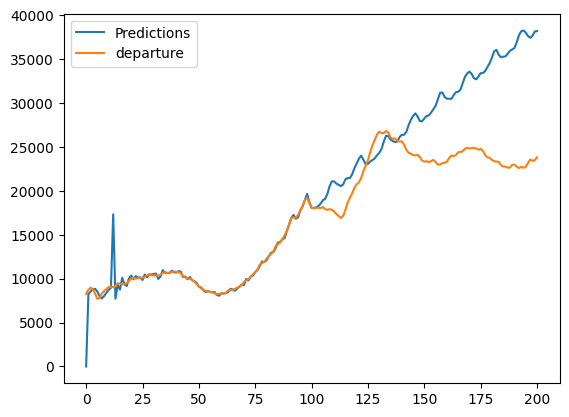

In [26]:

start = 0
end = 200
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
ukr_people_depart_poland_by_date['departure'][start:end+1].plot(legend = True) 


In [27]:

# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
rmse(ukr_people_depart_poland_by_date["departure"][start:end+1], predictions)/(max(ukr_people_depart_poland_by_date['departure'][20:301])-min(ukr_people_depart_poland_by_date['departure'][20:301]))
  

0.28125548798297845

## linear regressin

In [134]:
from sklearn.linear_model import LinearRegression


def create_dataset(return_df,lag=7):
    linreg_data = return_df.copy(deep=True)
    feat_columns = []
    for i in range(1,lag):
        linreg_data['x_'+str(i).zfill(2)] = linreg_data['departure'].shift(i)
        feat_columns.append('x_'+str(i).zfill(2))
    linreg_data = linreg_data.dropna(subset=feat_columns)
    return linreg_data,feat_columns

LAG_VAL = 31
train_size = 130

data,col = create_dataset(ukr_people_depart_poland_by_date,LAG_VAL)

x = data[0:train_size][col].values
y = data[0:train_size]['departure'].values

print(x.shape)
print(y.shape)

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model.intercept_}")

print(f"coefficients: {model.coef_}")

(130, 30)
(130,)
coefficient of determination: 0.9996800251801438
intercept: 34.50947245349744
coefficients: [ 2.24473148 -1.95398396  1.01058395 -0.33258052  0.01538505  0.05918362
  0.48179801 -1.31554156  1.35316276 -0.74438755  0.20805508 -0.07741375
  0.08827613  0.0872931  -0.78059552  1.2184813  -0.94450721  0.57195558
 -0.27092554  0.16110266 -0.18589186  0.54167786 -0.98809202  0.92012336
 -0.46337945  0.1468978  -0.1945746   0.33479184 -0.3012473   0.1081768 ]


## self-correcting prediction and rolling forecast

In [135]:
x_pred = data[col].values
y_pred = model.predict(x_pred)
data['departure_pred'] = y_pred

initial_pred = model.predict(x).tolist()
for remaining_period in range(0,len(data)-len(initial_pred)):
    cury = model.intercept_ + np.sum(model.coef_ * np.array(initial_pred[-LAG_VAL+1:]))
    #print(cury)
    initial_pred.append(cury)
    
data['departure_pred_2'] = initial_pred

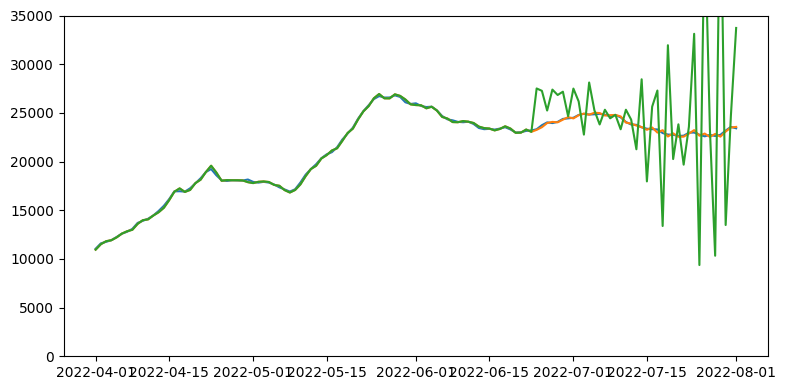

In [136]:
import matplotlib.pyplot as plt


cur_data = data[data.return_date>=pd.to_datetime('2022-04-01')]
cur_data = cur_data[cur_data.return_date<=pd.to_datetime('2022-08-01')]

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(cur_data['return_date'],cur_data['departure'])
ax.plot(cur_data['return_date'],cur_data['departure_pred'])
ax.plot(cur_data['return_date'],cur_data['departure_pred_2'])
ax.set_ylim([0,35000])
fig.tight_layout()

In [132]:
rmse(cur_data["departure"], cur_data['departure_pred'])/(max(ukr_people_depart_poland_by_date['departure'][20:301])-min(ukr_people_depart_poland_by_date['departure'][20:301]))

0.006467128671809426

In [133]:
rmse(cur_data["departure"], cur_data['departure_pred_2'])/(max(ukr_people_depart_poland_by_date['departure'][20:301])-min(ukr_people_depart_poland_by_date['departure'][20:301]))

0.02165603388069765